In [1]:
import os
import time
import numpy as np
import pandas as pd
# image manipulation
import cv2
import PIL
from PIL import Image

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# helpers
from tqdm import tqdm
import time
import copy
import gc
from enum import Enum


# for cnn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.autograd import Variable
from torch.utils.data import DataLoader, random_split, TensorDataset, Dataset, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from torchvision import models
from torchmetrics.classification import BinaryF1Score
from torchvision import transforms

In [2]:
csvpathtrain = '/kaggle/input/rsna-breast-cancer-detection/train.csv'

dftrain = pd.read_csv(csvpathtrain)
dftrain.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


Text(0.5, 0.98, 'Cancer distribution')

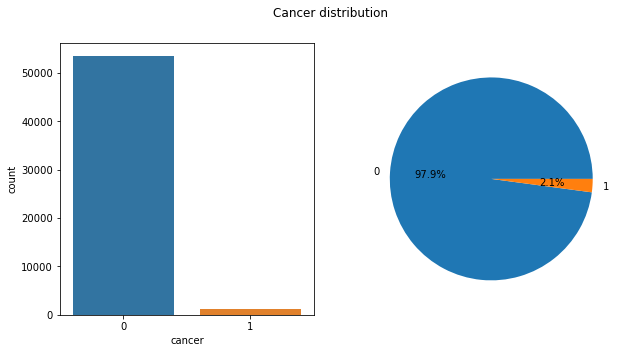

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
########## PLOTING CANCER ################
splot = sns.countplot(ax = axes[0], x = dftrain['cancer'])

s = dftrain['cancer'].value_counts()
axes[1].pie(s, autopct="%.1f%%", labels = s.keys())
fig.suptitle('Cancer distribution')

In [4]:
total_samples = len(dftrain['cancer'])
positive_samples = sum(dftrain['cancer'] == 1)
negative_samples = total_samples - positive_samples
print(f"{total_samples}, {positive_samples}, {negative_samples}")

54706, 1158, 53548


In [5]:
samples_weight = torch.Tensor([positive_samples / total_samples, negative_samples / total_samples]).type(dtype = torch.float32)

samples_weight

tensor([0.0212, 0.9788])

In [6]:
class RSNAMamographyDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.df = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    


    def __getitem__(self, ind):
        
        img_path = f"{self.img_dir}/{self.df.iloc[ind].patient_id}_{self.df.iloc[ind].image_id}.png"
        img = Image.open(img_path).convert('RGB')
        
        label = self.df.iloc[ind].cancer
        # there is no need to normalize data, it has already been normalized
        if self.transform:
            img = self.transform(img).to(torch.float32) 
        else:
            default_transform = transforms.Compose([transforms.ToTensor()])
            img = default_transform(img).to(torch.float32)
            
        #sample = {"image" : img, "label": label}
        return img, label

In [7]:
train_csv = '/kaggle/input/rsna-breast-cancer-detection/train.csv'
imgs_dir = '/kaggle/input/rsnamamorgaphybreastcancerrecognition512x512'

augmentator = transforms.Compose([
    # input for augmentator is always PIL image
    # transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation(5),
    transforms.ToTensor(), # return it as a tensor and transforms it to [0, 1]
])
dataset = RSNAMamographyDataset(train_csv, imgs_dir, augmentator)

In [8]:
# Use torch.utils.data to create a DataLoader 
# that will take care of creating batches 

# TODO, remove using half of dataset
# dataset, _ = random_split(dataset, [int(len(dataset)*0.02), int(len(dataset)*0.98 + 1)])
# split training into validation and train
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])



In [9]:
print("Class counting...")
labels = dftrain['cancer'].values
class_sample_count = np.array([len(np.where(labels == l)[0]) for l in np.unique(labels)])


# the trouble with this aproach is that it now has to load all images one by one and label them
# but it saves RAM memory in training process
#class_sample_count = np.zeros(2)

#print("Class counting...")
#for _, label in tqdm(train_dataset):
#    class_sample_count[label] += 1

print(class_sample_count)

# This maybe apply, maybe not
# since there is big class imbalance, we will not sample positive class THAT frequent
# to be closer to 'reality, every fifth image will be cancer (instead of 50/50 distribution)'
class_sample_count[1] *= 5
class_weights = 1. / class_sample_count

print("Adding weights to each training sample...")
sample_weights = []
for _, label in tqdm(train_dataset):
    sample_weights.append(class_weights[label])

sample_weights = np.array(sample_weights)
sample_weights = torch.from_numpy(sample_weights)


Class counting...
[53548  1158]
Adding weights to each training sample...


100%|██████████| 49236/49236 [10:53<00:00, 75.35it/s]


In [10]:
weighted_random_sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

In [11]:

batch_size = 32

# Applying random sampler just tu train dataset, not for validation, since the validation dataset should be imitation of 'real' DS
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers = 2, pin_memory = True, sampler = weighted_random_sampler)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle = True, pin_memory = True)


In [12]:
dataloaders = {'train' : train_dataloader, 'val' : val_dataloader}
dataset_sizes = {'train': train_size, 'val' : val_size}

In [13]:
print(len(train_dataset), len(val_dataset))
print(len(train_dataloader), len(val_dataloader))

49236 5470
1539 171


There are 26.0 negative and 6.0 positive samples in this batch.


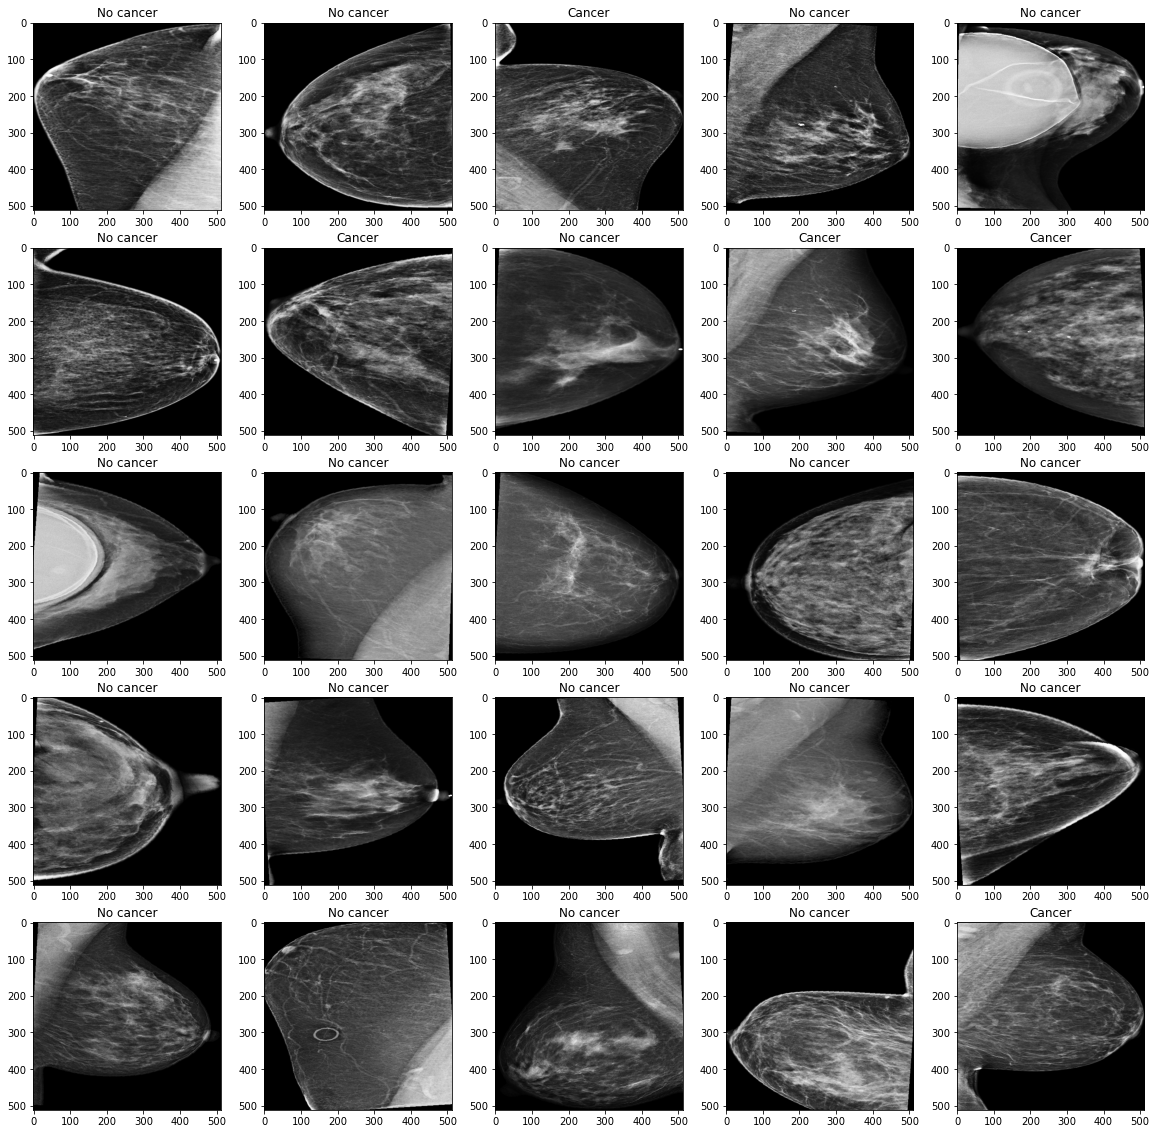

In [14]:
rows = 5
cols = 5
plt.subplots(rows, cols, figsize = (20, 20))

batch_imgs, batch_labels = next(iter(train_dataloader))
i = 0
for img in batch_imgs:
    if i >= rows*cols:
        break
    plt.subplot(rows, cols, i + 1)
    plt.title("Cancer" if batch_labels[i] == 1 else "No cancer")
    plt.imshow(img.permute(1, 2, 0))

    i += 1

labels_count = np.zeros(2)
for l in batch_labels:
    labels_count[l] += 1 
    
print(f'There are {labels_count[0]} negative and {labels_count[1]} positive samples in this batch.')

In [15]:
img.size()

torch.Size([3, 512, 512])

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Current device is {device}')

Current device is cuda


In [17]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.network = models.resnet18(pretrained=True)
        n_features = self.network.fc.out_features
        print(n_features)
        # add additional layer that maps 2048 extracted features from resnet to 1 feature determining the class
        self.classifier_layer = nn.Sequential(
            nn.Linear(n_features , 256),
            nn.Dropout(0.3),
            nn.Linear(256 , 1)
        )
    
    def forward(self, xb):        
        xb = self.network(xb)
        xb = self.classifier_layer(xb)
        return torch.sigmoid(xb)

In [18]:
# create class for earlystopping
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_loss = np.inf

    def early_stop(self, loss):
        if loss <= self.min_loss:
            self.min_loss = loss
            self.counter = 0
        elif loss > (self.min_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [19]:
def BCELoss_class_weighted(weights):
    """
    weights[0] is weight for class 0 (negative class)
    weights[1] is weight for class 1 (positive class)
    """
    def loss(y_pred, target):
        y_pred = torch.clamp(y_pred,min=1e-7,max=1-1e-7) # for numerical stability
        bce = - weights[1] * target * torch.log(y_pred) - (1 - target) * weights[0] * torch.log(1 - y_pred)
        return torch.mean(bce)

    return loss

In [20]:
# defining the model for determining LR
model = CNN()
model.to(device)
# convrt weights to cuda.float if cuda is avaliable
#if torch.cuda.is_available():
#    model.cuda()

# defining the optimizer
optimizer = Adam(model.parameters(), lr=1e-07)


# defining the loss function
# Binary cross entropy is chosen because it is the classification problem
#labels = dftrain['cancer'].values
#w_neg = sum(labels == 0) / len(labels)
#w_pos = sum(labels == 1) / len(labels)
#print(f"Class weight: {w_neg}")
#criterion = BCELoss_class_weighted(weights = [w_neg, w_pos])
# criterion = nn.BCEWithLogitsLoss()

w_pos = 3
w_neg = 1
print(f"Class weight for negative class: {w_neg}, and for positive {w_pos}")
criterion = BCELoss_class_weighted(weights = [w_neg, w_pos])

metric = BinaryF1Score().to(device)

# print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

1000
Class weight for negative class: 1, and for positive 3


In [21]:
model

CNN(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [22]:
def determine_lrs_and_losses(model, criterion, optimizer, metric, num_epochs=25, final_lr = 1e-02, total_batches = 1):
    since = time.time()
    
    lr_list = []
    loss_list = []
    
    train_metrics = {'loss' : [], 'acc' : [], 'f1': []}
    val_metrics = {'loss' : [], 'acc' : [], 'f1': []}
    
    
    print('Starting training...')
    print('-' * 20)
    for epoch in range(num_epochs):
        
        # Each epoch has a training and validation phase
        for phase in ['train']:
            
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_f1 = 0.0
            
           
            gc.collect()
            
            current_batch = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                
                labels = torch.unsqueeze(labels.to(torch.float32), 1)
                current_batch += 1
                if current_batch > total_batches:
                    break

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # this was different, it took max of output and 1
                    # output should never be higher than 1, so it is confusing
                    preds = outputs > 0.5
                    # _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs.double(), labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()  

                    #print(labels.detach().numpy().type,  outputs.detach().numpy().type)
                #running_f1 += f1_score(labels.detach().numpy(), outputs.detach().numpy())
                running_f1 += metric(outputs, labels)

                # statistics
                running_loss += loss.item() 
                #print(f'{phase}, {inputs.size(0)}, {preds.size()} {torch.squeeze(labels.data).size()}')
                running_corrects += torch.sum(preds == labels.data)
                
                gc.collect()

                
            
            epoch_loss = running_loss / total_batches 
            epoch_acc = running_corrects.double() / (total_batches * batch_size)
            epoch_f1 = running_f1 / total_batches
            if phase == 'train':
                train_metrics['loss'].append(epoch_loss)
                train_metrics['acc'].append(epoch_acc)
                train_metrics['f1'].append(epoch_f1)

            else:
                val_metrics['loss'].append(epoch_loss)
                val_metrics['acc'].append(epoch_acc)
                val_metrics['f1'].append(epoch_f1)

                
        train_loss_l, train_acc_l, train_f1_l = train_metrics['loss'][-1], train_metrics['acc'][-1], train_metrics['f1'][-1] # cant be formated in string, so should be segregated separately
        lr = optimizer.param_groups[0]['lr']
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss_l:.4f}, Train Acc: {train_acc_l:.4f}, Train f1: {train_f1_l:.4f}, learning rate: {lr}')

        # set learning rate for optimizer for determining initial learning rate
        for g in optimizer.param_groups:
            g['lr'] *= 4
        
        
        loss_list.append(train_loss_l) # the goal is to determine which learning rate results
        # in steepest training loss difference
        lr_list.append(optimizer.param_groups[0]['lr'])
        
        if optimizer.param_groups[0]['lr'] > final_lr:
            break

        

    return lr_list, loss_list

In [23]:
# function that finds steepest descent in training loss
def determine_init_lr(lr_list, loss_list):
    # find difference beetwen succesive losses
    diffs = [j-i for i, j in zip(loss_list[:-1], loss_list[1:])]
    # find where loss change is maximum
    max_value_ind = np.argmin(diffs) + 1
    # get learning rate for that change
    print(f"Learning rate {lr_list[max_value_ind]} resulted in biggest loss decrease and should be starting learning rate for this neural net")

    init_lr = lr_list[max_value_ind]
    return init_lr

In [24]:
def plot_lr_over_loss(lr_list, loss_list, init_lr):
    lr_ind = lr_list.index(init_lr)
    plt.figure(figsize = (15, 7))
    p1 = plt.plot(lr_list, loss_list)
    p2 = plt.scatter(lr_list, loss_list)
    p3 = plt.scatter(lr_list[lr_ind], loss_list[lr_ind], marker = 'D', s = 80, color = 'r')
    plt.legend((p2, p3), ("all considered learning rates", "best learning rate"))
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.show()

Starting training...
--------------------
Epoch 1/25, Train Loss: 0.8825, Train Acc: 0.7094, Train f1: 0.1006, learning rate: 1e-07
Epoch 2/25, Train Loss: 0.8813, Train Acc: 0.7531, Train f1: 0.1381, learning rate: 4e-07
Epoch 3/25, Train Loss: 0.9175, Train Acc: 0.7500, Train f1: 0.1416, learning rate: 1.6e-06
Epoch 4/25, Train Loss: 0.8150, Train Acc: 0.8281, Train f1: 0.0758, learning rate: 6.4e-06
Epoch 5/25, Train Loss: 0.8938, Train Acc: 0.8188, Train f1: 0.1341, learning rate: 2.56e-05
Epoch 6/25, Train Loss: 0.9963, Train Acc: 0.5719, Train f1: 0.3008, learning rate: 0.0001024
Epoch 7/25, Train Loss: 1.0988, Train Acc: 0.6813, Train f1: 0.1177, learning rate: 0.0004096
Epoch 8/25, Train Loss: 1.4817, Train Acc: 0.6063, Train f1: 0.2190, learning rate: 0.0016384
Epoch 9/25, Train Loss: 2.6492, Train Acc: 0.5438, Train f1: 0.1188, learning rate: 0.0065536
Learning rate 2.56e-05 resulted in biggest loss decrease and should be starting learning rate for this neural net


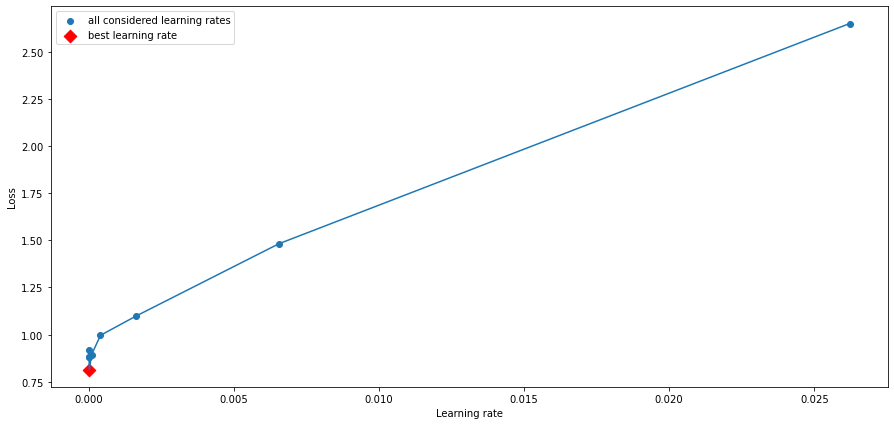

In [25]:
lr_list, loss_list = determine_lrs_and_losses(model, criterion, optimizer, metric, num_epochs=25, final_lr = 1e-02, total_batches = 10)
init_lr = determine_init_lr(lr_list, loss_list)
plot_lr_over_loss(lr_list, loss_list, init_lr)

In [26]:
# defining the model
model = CNN()
model.to(device)
# convrt weights to cuda.float if cuda is avaliable
#if torch.cuda.is_available():
#    model.cuda()

# defining the optimizer
optimizer = Adam(model.parameters(), lr=init_lr)
# defining learning rate schedualer to fight plateues
# TODO: figure out how to measure validation loss independently
# scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 5)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
# defining the loss function
# Binary cross entropy is chosen because it is the classification problem
labels = dftrain['cancer'].values
# the weight should be smaller if class count is higher
neg_count = sum(labels == 0)
pos_count = sum(labels == 1)
w_pos = 2
w_neg = 1
print(f"Class weight for negative class: {w_neg}, and for positive {w_pos}")
criterion = BCELoss_class_weighted(weights = [w_neg, w_pos])
# criterion = nn.BCEWithLogitsLoss()
# define early stopping
earlystoper = EarlyStopper(patience = 3)

metric = BinaryF1Score().to(device)

checkpoint = {'model': CNN(),
          'state_dict': model.state_dict(),
          'optimizer' : optimizer.state_dict()}


# print(model)

1000
Class weight for negative class: 1, and for positive 2
1000


In [27]:
def train_model(model, criterion, optimizer, metric, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = -1.0
    
    train_metrics = {'loss' : [], 'acc' : [], 'f1': []}
    val_metrics = {'loss' : [], 'acc' : [], 'f1': []}

    print('Starting training...')
    print('-' * 20)
    for epoch in range(num_epochs):
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            n_samples = 0
            
            n_correct = 0
            running_f1 = 0.0
            # Iterate over data.
            print(f'{phase} for epoch {epoch + 1}')
            for inputs, labels in tqdm(dataloaders[phase]):
                
                labels = torch.unsqueeze(labels.to(torch.float32), 1)
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = (outputs > 0.5).double()
                    #print(preds)
                    #print(outputs)
                    #print(labels)
                    # _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                n_samples += labels.size(0)
                running_loss += loss.item()
                n_correct += (preds == labels).sum().item()
                running_f1 += metric(outputs, labels) 


                # collect any unused memmory
                gc.collect()
                torch.cuda.empty_cache()
            
            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_f1 = running_f1 / len(dataloaders[phase])
            epoch_acc = float(n_correct) / n_samples
            
            if phase == 'train':
                scheduler.step()
                train_metrics['loss'].append(epoch_loss)
                train_metrics['acc'].append(epoch_acc)
                train_metrics['f1'].append(epoch_f1)

            else:
                val_metrics['loss'].append(epoch_loss)
                val_metrics['acc'].append(epoch_acc)
                val_metrics['f1'].append(epoch_f1)


            # deep copy the model
            if phase == 'val' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(checkpoint, 'checkpoint.pth')

                
                
        train_loss_l, train_acc_l, train_f1_l = train_metrics['loss'][-1], train_metrics['acc'][-1],  train_metrics['f1'][-1] # cant be formated in string
        val_loss_l, val_acc_l, val_f1_l = val_metrics['loss'][-1], val_metrics['acc'][-1], val_metrics['f1'][-1]
        lr = optimizer.param_groups[0]['lr']
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss_l:.4f}, Train Acc: {train_acc_l:.4f}, Train f1: {train_f1_l:.4f}, Valitadion Loss: {val_loss_l:.4f}, Validation Acc: {val_acc_l:.4f}, Vall f1: {val_f1_l:.4f}, learning rate: {lr}')

        if earlystoper.early_stop(val_loss_l):
            break
        
        
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val f1: {best_f1:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_metrics, val_metrics

In [28]:
model, train_metrics, val_metrics = train_model(model, criterion, optimizer, metric, scheduler, num_epochs=7)

Starting training...
--------------------
train for epoch 1


100%|██████████| 1539/1539 [14:55<00:00,  1.72it/s]


val for epoch 1


100%|██████████| 171/171 [02:20<00:00,  1.22it/s]


Epoch 1/7, Train Loss: 0.5895, Train Acc: 0.8259, Train f1: 0.3537, Valitadion Loss: 0.2714, Validation Acc: 0.9197, Vall f1: 0.1264, learning rate: 2.56e-05
train for epoch 2


100%|██████████| 1539/1539 [14:49<00:00,  1.73it/s]


val for epoch 2


100%|██████████| 171/171 [01:44<00:00,  1.64it/s]


Epoch 2/7, Train Loss: 0.4592, Train Acc: 0.8628, Train f1: 0.5706, Valitadion Loss: 0.2428, Validation Acc: 0.9229, Vall f1: 0.1389, learning rate: 2.56e-05
train for epoch 3


100%|██████████| 1539/1539 [14:34<00:00,  1.76it/s]


val for epoch 3


100%|██████████| 171/171 [01:38<00:00,  1.74it/s]


Epoch 3/7, Train Loss: 0.3306, Train Acc: 0.9029, Train f1: 0.7035, Valitadion Loss: 0.2377, Validation Acc: 0.9245, Vall f1: 0.1064, learning rate: 2.56e-05
train for epoch 4


100%|██████████| 1539/1539 [14:39<00:00,  1.75it/s]


val for epoch 4


100%|██████████| 171/171 [01:39<00:00,  1.73it/s]


Epoch 4/7, Train Loss: 0.2337, Train Acc: 0.9315, Train f1: 0.7860, Valitadion Loss: 0.1985, Validation Acc: 0.9572, Vall f1: 0.1195, learning rate: 2.56e-05
train for epoch 5


100%|██████████| 1539/1539 [14:45<00:00,  1.74it/s]


val for epoch 5


100%|██████████| 171/171 [01:40<00:00,  1.70it/s]


Epoch 5/7, Train Loss: 0.1748, Train Acc: 0.9507, Train f1: 0.8432, Valitadion Loss: 0.2211, Validation Acc: 0.9486, Vall f1: 0.1573, learning rate: 2.56e-06
train for epoch 6


100%|██████████| 1539/1539 [14:51<00:00,  1.73it/s]


val for epoch 6


100%|██████████| 171/171 [01:43<00:00,  1.65it/s]


Epoch 6/7, Train Loss: 0.0958, Train Acc: 0.9749, Train f1: 0.9142, Valitadion Loss: 0.2166, Validation Acc: 0.9678, Vall f1: 0.1125, learning rate: 2.56e-06
train for epoch 7


100%|██████████| 1539/1539 [14:52<00:00,  1.72it/s]


val for epoch 7


100%|██████████| 171/171 [01:40<00:00,  1.70it/s]

Epoch 7/7, Train Loss: 0.0743, Train Acc: 0.9797, Train f1: 0.9307, Valitadion Loss: 0.2404, Validation Acc: 0.9611, Vall f1: 0.1033, learning rate: 2.56e-06
Training complete in 115m 56s
Best val f1: 0.157310


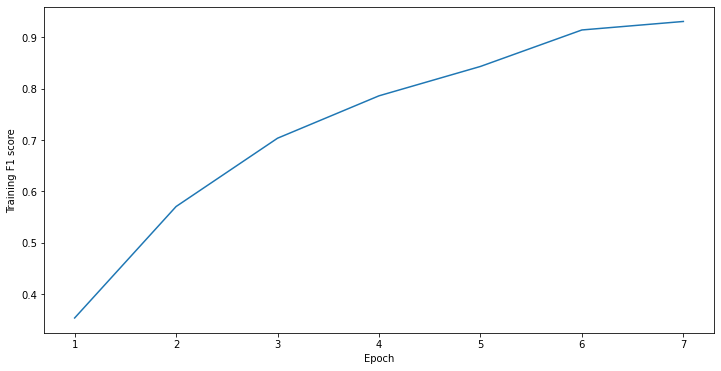

In [29]:
f1_train = [x.to('cpu') for x in train_metrics['f1']]
plt.figure(figsize = (12, 6))
plt.plot(range(1, len(f1_train) + 1), f1_train)
plt.xlabel("Epoch")
plt.ylabel("Training F1 score")
plt.show()

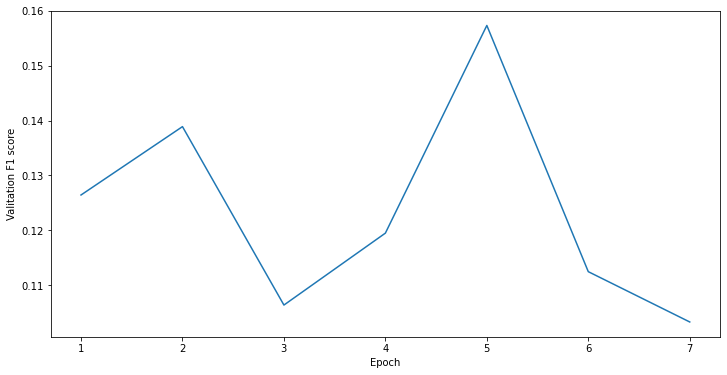

In [30]:
f1_val = [x.to('cpu') for x in val_metrics['f1']]
plt.figure(figsize = (12, 6))
plt.plot(range(1, len(f1_val) + 1), f1_val)
plt.xlabel("Epoch")
plt.ylabel("Valitation F1 score")
plt.show()

In [31]:
path_to_weights = '/kaggle/working/checkpoint.pth'

checkpoint = torch.load(path_to_weights)
model, best_weights, optimizer = checkpoint['model'], checkpoint['state_dict'], checkpoint['optimizer']
model.load_state_dict(best_weights)
model.to(device)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    false_positives = []
    false_negatives = []
    y_pred, y_true = [], []
    for images, labels in tqdm(val_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            predicted = outputs > 0.5
            n_samples += labels.size(0)
            n_correct += (torch.squeeze(predicted) == labels).sum().item()
            y_pred.append(np.array(torch.squeeze(predicted.cpu()), dtype = 'int32'))
            y_true.append(np.array(torch.squeeze(labels.cpu()), dtype = 'int32'))

            #if predicted != labels[i]:
            #    if predicted == 1:
            #        false_positives.append(images)
            #    else:
            #        false_negatives.append(images)
            
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the {n_samples} test images: {acc} %')

    y_true = np.concatenate(y_true, axis = 0)
    y_pred = np.concatenate(y_pred, axis = 0)

100%|██████████| 171/171 [01:13<00:00,  2.34it/s]

Accuracy of the network on the 5470 test images: 92.12065813528336 %


In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

<AxesSubplot:>

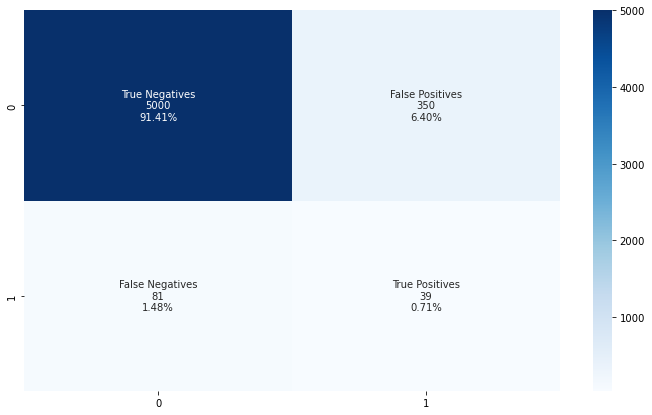

In [33]:
cm = confusion_matrix(np.squeeze(np.array(y_true, dtype = 'int32')), np.squeeze(np.array(y_pred, dtype = 'int32')))
group_names = ['True Negatives','False Positives', 'False Negatives','True Positives']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize = (12,7))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

